In [1]:
import pandas as pd
import numpy as np
import requests
import data_getter as dg
import time
import os
from lxml import etree
import datetime
# pd.options.display.max_rows = 999
# pd.reset_option("display.max_rows")
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", 999)

In [2]:
boxscore_list_df = dg.get_boxscore_list_to_df()
game_id_list = list(boxscore_list_df.GAME_ID.unique())

In [3]:
pp_df_dict = {}
for i in game_id_list:
    filename = "data/pp/"+"pp_"+str(i)+".csv"
    if os.path.isfile(filename):
        pp_df = pd.read_csv(filename)
    else:   
        pp_df = dg.get_one_game_play_to_play_to_df(game_id=i) 
        pp_df.to_csv("data/pp/"+"pp_"+str(i)+".csv", header=True, index=False)
    pp_df_dict[i] = pp_df
    time.sleep(0.25)

KeyboardInterrupt: 

In [3]:
team_games_log_df = dg.get_team_games_log(team_id=1610612744, season="2017-18", season_type="Regular Season")

In [4]:
team_games_log_df.head()

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612744,0021700494,2017-12-25,GSW vs. CLE,W,27,7,0.794,240,38,82,0.463,10,37,0.270,13,17,0.765,10,37,47,28,7,8,15,18,99
1,1610612744,0021700489,2017-12-23,GSW vs. DEN,L,26,7,0.788,240,32,83,0.386,3,27,0.111,14,17,0.824,11,27,38,25,14,8,17,14,81
2,1610612744,0021700479,2017-12-22,GSW vs. LAL,W,26,6,0.813,240,42,85,0.494,7,24,0.292,22,27,0.815,10,32,42,24,9,13,15,17,113
3,1610612744,0021700464,2017-12-20,GSW vs. MEM,W,25,6,0.806,240,34,74,0.459,7,21,0.333,22,25,0.880,14,30,44,26,9,8,16,19,97
4,1610612744,0021700450,2017-12-18,GSW @ LAL,W,24,6,0.800,265,43,107,0.402,11,34,0.324,19,21,0.905,15,46,61,25,6,10,14,26,116


In [5]:
after2001_pows_df = dg.get_bbr_nickname_player_of_week_list()

In [6]:
after2001_pows_df.head()

,season,week,division,pow_name,REWARD_DATE
0,2001-02,Nov 4,east,Ray Allen,2001-11-04
1,2001-02,Nov 4,west,Kobe Bryant,2001-11-04
2,2001-02,Nov 11,east,Vince Carter,2001-11-11
3,2001-02,Nov 11,west,Tim Duncan,2001-11-11
4,2001-02,Nov 18,east,Allen Iverson,2001-11-18


In [7]:
before2001_pows_df = dg.get_bbr_nickname_player_of_week_list(after_2001=False)
before2001_pows_df.head()

,season,week,division,pow_name,REWARD_DATE
0,1979-80,Oct 21,,Julius Erving,1979-10-21
1,1979-80,Oct 28,,Micheal Ray Richardson,1979-10-28
2,1979-80,Nov 4,,Marques Johnson,1979-11-04
3,1979-80,Nov 11,,Magic Johnson,1979-11-11
4,1979-80,Nov 18,,Phil Ford,1979-11-18


In [8]:
after2001_pows_df.to_csv("data/after2001_pows_list.csv")
before2001_pows_df.to_csv("data/before2001_pows_list.csv")

In [9]:
player_list_df, team_list_df = dg.get_all_players_n_teams_ids()

/Users/ccuulinay/PycharmProjects/nba_data/nba_analysis/data_getter.py:65: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric=True)


In [45]:
import datetime
from tqdm import tqdm

In [46]:
def get_pow_diff_stat_df(pow_df, player_list_df):
    diff_stat_values_list = []
    for index,row in tqdm(after2001_pows_df.iterrows()):
        player_name = row.pow_name
        player = player_list_df[player_list_df.DISPLAY_FIRST_LAST == row.pow_name]
        if len(player) == 0:
            player_name = str(row.pow_name).replace(".","")
            player = player_list_df[player_list_df.DISPLAY_FIRST_LAST == player_name]
            if len(player) == 0:
                er = "Invalid player name passed or there is no player with that name."
                raise ValueError(er)
        player_id = player_list_df[player_list_df.DISPLAY_FIRST_LAST == player_name].PERSON_ID.values[0]
        b_begin_date = (row.REWARD_DATE - datetime.timedelta(days=7)).strftime('%m/%d/%Y')
        b_end_date = row.REWARD_DATE.strftime('%m/%d/%Y')
        l_begin_date = row.REWARD_DATE.strftime('%m/%d/%Y')
        l_end_date = (row.REWARD_DATE + datetime.timedelta(days=7)).strftime('%m/%d/%Y')
        player_season = row.season
        
        b_test_df = dg.get_player_games_log(player_id, begin_date=b_begin_date, end_date=b_end_date,season=player_season)
        l_test_df = dg.get_player_games_log(player_id, begin_date=l_begin_date, end_date=l_end_date,season=player_season)
        
        stat_cols = [c for c in b_test_df.columns if not c.lower().endswith("_rank")]
        b_test_df = b_test_df[stat_cols]
        l_test_df = l_test_df[stat_cols]
        
        stat_cols = list((l_test_df.iloc[:,10:].mean() - b_test_df.iloc[:,10:].mean()).index.values)
        diff_stat_values = (l_test_df.iloc[:,10:].mean() - b_test_df.iloc[:,10:].mean()).values
        
        diff_stat_values_list.append(list(diff_stat_values))
        # time.sleep(0.15)
    diff_stat_df = pd.DataFrame(diff_stat_values_list, columns=stat_cols)
    return diff_stat_df

In [47]:
test_df = get_pow_diff_stat_df(after2001_pows_df, player_list_df)

732it [20:47,  1.77s/it]


In [56]:
test_df = test_df.add_prefix("stat_")

In [57]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 25 columns):
stat_MIN                728 non-null float64
stat_FGM                728 non-null float64
stat_FGA                728 non-null float64
stat_FG_PCT             728 non-null float64
stat_FG3M               728 non-null float64
stat_FG3A               728 non-null float64
stat_FG3_PCT            728 non-null float64
stat_FTM                728 non-null float64
stat_FTA                728 non-null float64
stat_FT_PCT             728 non-null float64
stat_OREB               728 non-null float64
stat_DREB               728 non-null float64
stat_REB                728 non-null float64
stat_AST                728 non-null float64
stat_TOV                728 non-null float64
stat_STL                728 non-null float64
stat_BLK                728 non-null float64
stat_BLKA               728 non-null float64
stat_PF                 728 non-null float64
stat_PFD                728 non-null flo

In [50]:
after2001_pows_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 5 columns):
season         732 non-null object
week           732 non-null object
division       732 non-null object
pow_name       732 non-null object
REWARD_DATE    732 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 28.7+ KB


In [58]:
diff_stat_df = pd.concat([after2001_pows_df, test_df], axis=1)

In [60]:
diff_stat_df.to_csv("data/pows_diff_stat_by_20171225.csv")

In [65]:
# ax = diff_stat_df.plot()
# ax.axhline(kind="barh",y="stat_NBA_FANTASY_PTS", x="REWARD_DATE", color='r', linestyle='--')
import matplotlib
%matplotlib inline


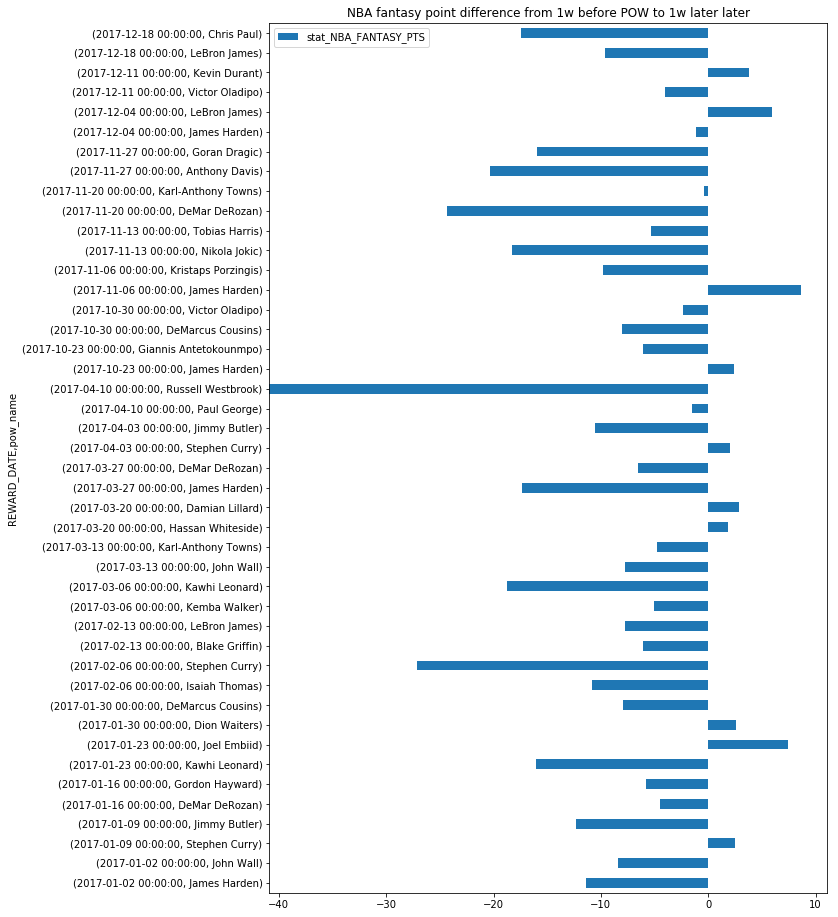

In [77]:
ax = diff_stat_df[diff_stat_df.REWARD_DATE > "2017-01-01"].plot(
    figsize=(10,16),y='stat_NBA_FANTASY_PTS',x=['REWARD_DATE','pow_name'], kind='barh',
    title='NBA fantasy point difference from 1w before POW to 1w later later'
)
# for b in ax.patches:
#     ax.annotate("x")